# Introduction
Calculations for the paper
"Heliostat fields with a balanced mirror density"

In [1]:
import math
import mathutils as mu
import numpy as np
import copy 
import time

from tqdm.notebook import tqdm_notebook # for progress bars

from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import PchipInterpolator
from scipy import optimize

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.colors
import matplotlib.ticker as mtick
import matplotlib.patches as patches
colorAxes = '#303030'
colorGrid = '#B0B0B0FF'

import sunpath as sp
degree = math.pi/180

In [2]:
#!pip install sp

In [3]:
location = sp.Location(
    "Proteas, Cyprus", 
    sp.PointGeographic(latitude=34.707*sp.degree, longitude=33.261*sp.degree),
    sp.timedelta(hours=2)
)
sunCalculator = sp.SunCalculator(location)
sunTemporal = sp.SunTemporal(sunCalculator)
sunTemporal.sampleYear(2021, sp.timedelta(minutes=60), sp.irradianceIneichen)

ht = 100. # tower height

# Definitions

## Functions

In [4]:
# faster than np.clip
def clip(x: float, a: float, b: float) -> float: 
    return min(max(x, a), b)

In [5]:
# cosine factor
def eta_c(s: mu.Vector, t: mu.Vector) -> float:
    q = (s + t).length/2.
    if q > 1.: q = 1.
    return q

In [6]:
# atmospheric transmission 
# Vittitoe and Biggs model for clear day
def etaAtmVB(d: float) -> float:
    d /= 1000.
    return 0.99326 - 0.1046*d + 0.017*d*d - 0.002845*d*d*d

In [7]:
# atmospheric transmission
# Leary and Hankins model (Mirval)
def etaAtmLH(d: float) -> float:
    d /= 1000.
    if d <= 1.:
        return 0.99321 - 0.1176*d + 0.0197*d*d
    else:
        return math.exp(-0.1106*d)

In [8]:
# transmission factor
def eta_t(t: mu.Vector) -> float:
    if t.z > 0.:
        return etaAtmLH(ht/t.z)
    return 0.

In [9]:
# visibility factor
def eta_v(s: mu.Vector, t: mu.Vector, sigma: float) -> float:
    if sigma == 0.: return 1.
    cs = eta_c(s, t)*sigma
    v = min(1., t.z/cs, s.z/cs)
    return v

def eta_b(s: mu.Vector, t: mu.Vector, sigma: float) -> float:
    if sigma == 0.: return 1.
    cs = eta_c(s, t)*sigma
    v = min(1., t.z/cs)
    return v

def eta_s(s: mu.Vector, t: mu.Vector, sigma: float) -> float:
    if sigma == 0.: return 1.
    cs = eta_c(s, t)*sigma
    v = min(1., s.z/cs)
    return v

In [10]:
# irradiance (DNI)
# Ineichen model for clear sky
def irradianceIneichen(s: mu.Vector) -> float:
    if s.z <= 0.:
        return 0.
    else:
        return 1618.*math.exp(-0.606/s.z**0.491)

## Annual weights

In [11]:
sunSpatial = sp.SunSpatial(sunCalculator)
rho = 2*sunCalculator.obliquity/3
sunSpatial.sampleEquatorial(rho) 
sunSpatial.info()

points: 50


In [12]:
# preconditioner
# pFunc = lambda s: 1
# pFunc = lambda s: 1 + s.z
pFunc = lambda s: math.exp(1*s.z)

methodRBFn = sp.InterpolationMethod('RBF-3D', kernel='polyharmonic', order=6, precondition=pFunc)
# methodRBFn = sp.InterpolationMethod('triangular', order=2, precondition=pFunc)
methodRBFn.findWeights(sunTemporal, sunSpatial, pFunc)

In [13]:
# sunSpatialRect = sp.SunSpatial(sunCalculator)
# rho = 2*sunCalculator.obliquity/3
# sunSpatialRect.sampleEquatorial(rho, True) 
# sunSpatialRect.info()

In [14]:
# pFunc = lambda s: 1
# methodRBFn = sp.InterpolationMethod('B-spline', order=[3, 3], precondition=pFunc)
# methodRBFn.findWeights(sunTemporal, sunSpatialRect, pFunc)

In [15]:
np.sum(sunSpatial.nodesW) # insolation
sampling_s = sunSpatial.nodesV
sampling_w = np.array(sunSpatial.nodesW)
sampling_w /= np.sum(sampling_w)

## Annual efficiencies

In [16]:
def eta_c_max(t: mu.Vector) -> float:
    """
    :param t: target vector
    :return: maximal cosine factor
    """
    tE = sunCalculator.findEquatorialFromVector(t)
    deltaMax = sunCalculator.obliquity
    deltaS = clip(tE.declination(), -deltaMax, deltaMax)
    omegaMax = sunCalculator.findHourAngleMax(deltaS)
    omegaS = clip(tE.hourAngle(), -omegaMax, omegaMax)
    sE = sp.PointEquatorial(omegaS, deltaS)
    s = sunCalculator.findVectorFromEquatorial(sE)
    return eta_c(s, t)

In [17]:
# average cosine factor
def eta_c_av(t: mu.Vector) -> float:
    etaTotal = 0.
    for s, w in zip(sampling_s, sampling_w):
        etaTotal += w*eta_c(s, t)
    return etaTotal

In [18]:
# average cosine and transmission factor
def eta_ct_av(t: mu.Vector) -> float:
    etaTotal = 0.
    for s, w in zip(sampling_s, sampling_w):
        etaTotal += w*eta_c(s, t)
    return etaTotal*eta_t(t)

In [19]:
# average visibility factor
def eta_v_av(t: mu.Vector, sigma: float) -> float:
    etaTotal = 0.
    for s, w in zip(sampling_s, sampling_w):
        etaTotal += w*eta_v(s, t, sigma)
    return etaTotal

def eta_b_av(t: mu.Vector, sigma: float) -> float:
    etaTotal = 0.
    for s, w in zip(sampling_s, sampling_w):
        etaTotal += w*eta_b(s, t, sigma)
    return etaTotal

def eta_s_av(t: mu.Vector, sigma: float) -> float:
    etaTotal = 0.
    for s, w in zip(sampling_s, sampling_w):
        etaTotal += w*eta_s(s, t, sigma)
    return etaTotal

In [20]:
def eta_cvt_av(t: mu.Vector, sigma: float) -> float:
    """
    :param t: target vector
    :param sigma: mirror density
    :return: average mirror efficiency
    """
    #if sigma == 0.: return 0. # comment for smooth
    etaTotal = 0.
    for s, w in zip(sampling_s, sampling_w):
        etaTotal += w*eta_c(s, t)*eta_v(s, t, sigma)
    return etaTotal*eta_t(t)

## Mirror density

In [21]:
sigma_d = math.pi/(2*math.sqrt(3)) # disks
sigma_s = 2/math.pi # squares
sigma_N = sigma_d*sigma_s # compact packing in near zone
[sigma_d, sigma_s, sigma_N]

[0.9068996821171089, 0.6366197723675814, 0.5773502691896258]

In [22]:
# tower infrastructure
r_TN = 0.75 # in tower heights
alpha_TN = math.atan(1/r_TN)

# near layout
alpha_NF = math.asin(sigma_N)
r_NF = 1/math.tan(alpha_NF)

In [23]:
print([r_TN, r_NF])
print([alpha_TN/degree, alpha_NF/degree]) 

[0.75, 1.414213562373095]
[53.13010235415598, 35.264389682754654]


In [24]:
# mirror density (sigma_Delta)
def sigma_CB(t: mu.Vector) -> float:
    eta_c_max = 1.
    return min(sigma_N, t.z/eta_c_max)

# mirror density with maximal cosine (sigma_Nabla)
def sigma_CBm(t: mu.Vector) -> float:
    ecm = eta_c_max(t)
    return min(sigma_N, t.z/ecm)

In [25]:
# balanced mirror density
def sigma_Balanced(tV: mu.Vector, eta_b: float, useEtaM: bool = True) -> float:
    sigma0 = sigma_CB(tV)
    sigmaStep = 0.001
    
    if useEtaM:
        etaM = eta_ct_av(tV)
        if etaM == 0.: return 0. 
        eta_b /= etaM
        if eta_b >= 1.: return 0. 
    
    def fr(sigma: float) -> float:
        sA = sigma - 0.5*sigmaStep
        sB = sigma + 0.5*sigmaStep
        fA = eta_v_av(tV, sA)*sA
        fB = eta_v_av(tV, sB)*sB
        return (fB - fA)/sigmaStep - eta_b
    
    if fr(sigma_N) >= 0: return sigma_N
    if fr(sigmaStep) <= 0.: return 0.
        
    sol = optimize.root_scalar(fr, x0=sigma0, bracket=[sigmaStep, sigma_N], method='bisect', xtol=0.001, rtol=0.001, maxiter=30)
    ans = sol.root
    
    return ans

## Mesh

In [26]:
def sampleInterval(a: float, b: float, rho: float, middle: bool = False) -> np.ndarray:
    """
    :param a: interval begin
    :param b: interval end
    :param rho: resolution
    :param middle: use interval centers (true) or ends (false) 
    :return: points
    """
    n = round((b - a)/rho)
    if middle:
        step = (b - a)/n 
        return np.linspace(a + step/2, b - step/2, n)
    else:
        return np.linspace(a, b, n + 1)    

In [27]:
resolution = 1*degree
gammas = sampleInterval(0*degree, 360*degree, resolution, True)
alphas = sampleInterval(0*degree, 90*degree, resolution, True)
gammaStep = gammas[1] - gammas[0] # del?
alphaStep = alphas[1] - alphas[0]

In [28]:
data_pH_2D = [[
    sp.PointHorizontal(gamma, alpha)
for alpha in alphas]
for gamma in gammas]
data_pH = np.array(data_pH_2D).flatten()
data_pE = [sunCalculator.findEquatorialFromHorizontal(q) for q in data_pH]
data_pV = [sunCalculator.findVectorFromHorizontal(q) for q in data_pH]
#data_pV_2D = [[sunCalculator.findVectorFromHorizontal(q) for q in line] for line in data_pH_2D]

In [29]:
data_deltas = [q.declination() for q in data_pE]
deltaMax = sunCalculator.obliquity

In [30]:
def toPolar(p: sp.PointHorizontal):
    azimuth = p.azimuth()
    elevation = p.elevation()
    r = 1 - elevation/(90*degree)
    return [r*math.sin(azimuth), r*math.cos(azimuth)]

def toPolarX(azimuth, elevation):
    return toPolar(sp.PointHorizontal(azimuth, elevation))

data_pP = np.array([toPolar(q) for q in data_pH])
meshPolar = tri.Triangulation(data_pP[:, 0], data_pP[:, 1])

In [31]:
def toHorizontalPlane(p: sp.PointHorizontal):
    t = sp.SunCalculator.findVectorFromHorizontal(p)
    tau = 1/t.z # in tower units
    x = np.clip(-t.x*tau, -100, 100)
    y = np.clip(-t.y*tau, -100, 100)
    return [x, y]

data_pHP = np.array([toHorizontalPlane(q) for q in data_pH])
meshHorizontal = copy.deepcopy(meshPolar)
meshHorizontal.x = data_pHP[:, 0]
meshHorizontal.y = data_pHP[:, 1]

In [32]:
def makePolarGrid(ax, **kwargs):   
    cGrid = '#00000015'
    wGrid = 2.5
    
    # elevation const
    rs = [math.sqrt(q[0]**2 + q[1]**2) for q in data_pP]
    ax.tricontour(meshPolar, rs, levels=[0.333, 0.667],
                  colors=cGrid, linewidths=wGrid)
    
    if kwargs.get('elevlab', True):
        for alpha in np.arange(30, 90, 30):
            xy = toPolarX(0, alpha*degree)
            plt.text(xy[0], xy[1], str(alpha), ha='center', va='center')
    
    plt.text(0, 0, 'Z', horizontalalignment='center', verticalalignment='center')    
    
    # azimuth const
    for gamma in np.arange(0, 360, 30):
        xy = toPolarX(gamma*degree, 0)
        rmin = 0.07
        if gamma % 90 == 0:
            ax.plot([rmin*xy[0], xy[0]], [rmin*xy[1], xy[1]], color=cGrid, linewidth=wGrid)

        if gamma == 0:
            lt = 'N'
        elif gamma == 90:
            lt = 'E'
        elif gamma == 180:
            lt = 'S'   
        elif gamma == 270:
            lt = 'W'       
        else:
            lt = str(gamma)
            
        if xy[1] > 0.1:
            r = 1.03
            ra = -gamma
        elif xy[1] < -0.1:
            r = 1.08
            ra = -gamma + 180
        else:
            r = 1.08
            ra = 0

        plt.text(r*xy[0], r*xy[1], lt, rotation=ra, rotation_mode='anchor', ha='center')

    # declinations    
    ax.tricontour(meshPolar, data_deltas, levels=[-deltaMax, deltaMax],
                  colors='#ffffff80', linewidths=wGrid, linestyles='solid')
     
    if kwargs.get('zones', True):    
        for a in [alpha_TN, alpha_NF]:
            ax.add_patch(
                patches.Circle(
                    (0, 0), toPolarX(0, a)[1],
                    edgecolor='#50505080', lw=1, ls='--', facecolor='none', zorder=3)
            )

    plt.axis('off')
    fig.tight_layout() 

In [33]:
def makeHorizontalGrid(ax, **kwargs):
    cGrid = '#0000001A'
    
    # declinations
    ax.tricontour(meshHorizontal, data_deltas, levels=[-deltaMax, deltaMax], 
                  linewidths=2.5, colors='#ffffff80', linestyles='solid')
    # hxs, hys, meshPolar.triangles

    for v in [0]:
        ax.axvline(x=v, c=cGrid, ls='--', lw=0.5)
    for v in [0]:
        ax.axhline(y=v, c=cGrid, ls='--', lw=0.5)

    ax.set_xlabel(r'$x \, / \,h_t$')
    ax.xaxis.set_major_locator(mtick.MultipleLocator(5))
    ax.xaxis.set_minor_locator(mtick.MultipleLocator(1))

    ax.set_ylabel(r'$y \, / \, h_t$')
    ax.yaxis.set_major_locator(mtick.MultipleLocator(5))
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(1))

    ax.tick_params(which='both', direction='in', top=True, right=True, width=0.5, color=colorAxes)
    ax.tick_params(which='major', length=3)
    ax.tick_params(which='minor', length=1.5)

    for spine in ax.spines.values():
        spine.set_edgecolor(colorAxes)
        spine.set_linewidth(0.5)

In [34]:
CS1_params = {'cmap': sp.colorMapL, 'extend': 'both', 'zorder': -2}
CS2_params = {'colors': '#00000020', 'linewidths': 0.3, 'linestyles': 'solid'}
CS3_params = {'colors': '#00000050', 'linewidths': 0.3, 'linestyles': 'solid'}
CS0_params = {'colors': '#00000000', 'linewidths': 0.3, 'linestyles': 'solid'}
CL_params = {'fontsize': 7, 'colors': '#000000'} 

In [35]:
def makeFigurePolar():
    fig, ax = plt.subplots()
    fig.set_size_inches(3.5, 3.5)
    fig.set_dpi(150)
    ax.set_aspect('equal')  
    return fig, ax

In [36]:
def makeFigureHorizontal():    
    fig, ax = plt.subplots()
    fig.set_size_inches(3.5, 3.5)
    fig.set_dpi(150)
    ax.set_aspect('equal')
    ax.set_xlim(-15, 15)
    ax.set_ylim(-10, 20)
    return fig, ax

## Visualizations

In [37]:
def plotBalancing(gamma, alpha, eta_bound, smoothing=0., etaText=r'\bar{\eta}_m'):  
    tH = sp.PointHorizontal(gamma*sp.degree, alpha*sp.degree) 
    tV = sp.SunCalculator.findVectorFromHorizontal(tH)
    
    if etaText == r'\eta_b':
        bIdeal=True
    else:
        bIdeal=False
        
    if etaText == r'\bar{\eta}_b':
        bEtaV=True
        eta_q_av = eta_b_av
    elif etaText == r'\bar{\eta}_s':
        bEtaV=True
        eta_q_av = eta_s_av
    elif etaText == r'\bar{\eta}_v':    
        bEtaV=True
        eta_q_av = eta_v_av
    elif etaText == r'\eta_b':    
        bEtaV=True
        eta_q_av = eta_b_av # fake     
    else:    
        bEtaV=False
        eta_q_av = eta_v_av        
    
    sigmas = np.linspace(0.001, 0.999, 101, endpoint=True)
    ds = sigmas[1] - sigmas[0]

    if bIdeal: 
        if bEtaV:
            eta_m = 1.
        else:
            eta_m = 0.8
        sigma_B = 0.4
        ys = [eta_m if s < sigma_B else eta_m*sigma_B/s for s in sigmas] 
    else:
        if bEtaV:
            eta_m = 1.
            sigma_B = sigma_CBm(tV)
        else:
            eta_m = eta_ct_av(tV)
            sigma_B = sigma_Balanced(tV, eta_bound)
        
        ys = [eta_m*eta_q_av(tV, s) for s in sigmas] 
    print(sigma_B)
    
    
    if smoothing > 0:
        fys = UnivariateSpline(sigmas, ys, k=4, s=smoothing)
        ys = [fys(s) for s in sigmas]
        ys2 = [fys(s)*s for s in sigmas]
        ys3 = [fys.derivative(1)(s)*s + fys(s) for s in sigmas]
    else:
        ys2 = [y*s for s, y in zip(sigmas, ys)]
#         ys3 = [(y*s[n + 1] - ys2[n])/ds for n in range(len(ys) - 1)] + [0]
        ds = 0.0001
        def der(s):
            return eta_m*eta_q_av(tV, s)*s
        ys3 = [(der(s+0.5*ds) - der(s-0.5*ds))/ds for s in sigmas] 
    
        if bIdeal: 
            dy = 0.03
            ys3 =[eta_m - dy if s < sigma_B else dy for s in sigmas] 
        
#     ys = [eta_v_av(tV, s)*s for s in sigmas]
#     fys = UnivariateSpline(sigmas, ys, k=4, s=0.0001)
# #     fys = PchipInterpolator(sigmas, ys) # stepwise
# #     fys = interp1d(sigmas, ys, kind="cubic") # no derivative
#     ys = [fys(s)/s for s in sigmas]
#     ys2 = [fys(s) for s in sigmas]
#     ys3 = [fys.derivative(1)(s) for s in sigmas]

    fig, ax = plt.subplots()
    fig.set_size_inches(3.5, 1.7)
    if etaText==r'\bar{\eta}_m':
        fig.set_size_inches(3.5, 1.8)
    fig.set_dpi(150)
    
    ax.plot(sigmas, ys, label='$' + etaText + '$') # blue
    ax.plot(sigmas, ys2, label='$' + etaText + r'\sigma$', color="#c68635") # orange
    ax.plot(sigmas, ys3, label='$(' + etaText + r'\sigma)^\prime_\sigma$', marker='.', markevery=10, color="#2CA02C") # green, derivative
    ax.fill_between(sigmas, ys2, 0, color="#cc8d3e30") # orange  FF801120
                  
    ax.set_xlabel(r'$\sigma$')
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_locator(mtick.MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(mtick.MultipleLocator(0.05))

    ax.set_ylabel('$' + etaText + '$', rotation=0, labelpad=12)
    if bEtaV:
        ax.set_ylim(0., 1.35)
    else:           
        ax.set_ylim(0., 1.1)
    ax.yaxis.set_major_locator(mtick.MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.05))

    ax.tick_params(which='both', direction='in', top=True, right=True, width=0.5, color=colorAxes)
    ax.tick_params(which='major', length=3)
    ax.tick_params(which='minor', length=1.5)

    for spine in ax.spines.values():
        spine.set_edgecolor(colorAxes)
        spine.set_linewidth(0.5)
    
#     if bIdeal:
#         ax.plot(0.995*sigma_B, [eta_m - dy], color = "#2CA02C",  marker='.')
        
    if not bIdeal:
        s_low = sigma_CB(tV)  
        s_up = sigma_CBm(tV)
    else:
        s_low = sigma_B
        s_up = sigma_B

    if bEtaV:
        for v in [sigma_B]:
            ax.axvline(x=v, c=colorGrid, ls='--', lw=0.5, zorder=-1)
#         for v in [s_low]:
#             ax.axvline(x=v, ymin=0., ymax=0.5, c=colorGrid, ls='--', lw=0.5, zorder=-1)

#         for v in [s_up]:
#             ax.axvline(x=v, ymin=0.5, ymax=1, c=colorGrid, ls='--', lw=0.5, zorder=-1)
    else:
        for v in [s_low]:
            ax.axvline(x=v, ymin=0., ymax=0.2, c=colorGrid, ls='--', lw=0.5, zorder=-1)

        for v in [s_up]:
            ax.axvline(x=v, ymin=0.8, ymax=1, c=colorGrid, ls='--', lw=0.5, zorder=-1)
    
        for v in [eta_bound]:
            ax.axhline(y=v, c=colorGrid, ls=':', lw=0.5, zorder=-1)

        for v in [sigma_B]:
            ax.axvline(x=v, c=colorGrid, ls=':', lw=0.5, zorder=-1)
            
    plt.legend(loc="upper right", frameon=False, labelspacing=0.25)  
    fig.tight_layout() 
    return fig

# Mirror density

## Blocking losses

In [38]:
tH = sp.PointHorizontal(240*sp.degree, 50*sp.degree) 
t = sp.SunCalculator.findVectorFromHorizontal(tH)
data_eta_c = [eta_c(s, t) for s in data_pV]

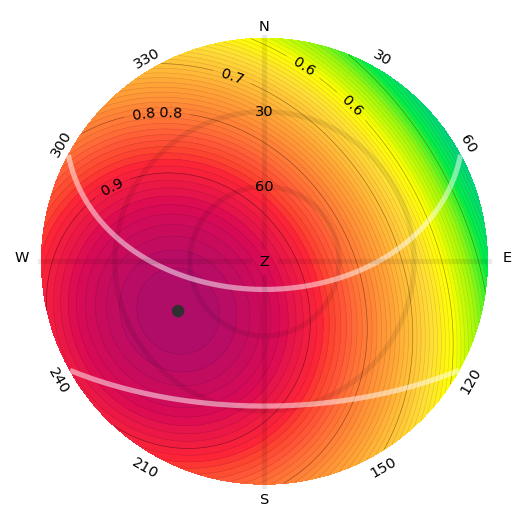

In [39]:
fig, ax = makeFigurePolar()

CS = ax.tricontourf(meshPolar, data_eta_c, levels=np.arange(0.2, 1.001, 0.01), **CS1_params)
CS2 = ax.tricontour(meshPolar, data_eta_c, levels=CS.levels[::1], **CS2_params)
CS3 = ax.tricontour(meshPolar, data_eta_c, levels=CS.levels[::10], **CS3_params)
ax.clabel(CS3, fmt='%0.1f', manual=[
    toPolarX(300*degree, 15*degree),
    toPolarX(330*degree, 15*degree),
    toPolarX(320*degree, 15*degree),
    toPolarX(350*degree, 15*degree),
    toPolarX(10*degree, 15*degree),
    toPolarX(30*degree, 15*degree)
], **CL_params)

# tower
scp = toPolar(tH) 
ax.scatter([scp[0]], [scp[1]], edgecolors='none', c='#303030')

makePolarGrid(ax, zones=False)
#fig.savefig("eta_c.png", dpi=300)

## Maximal cosine factor

In [40]:
data_eta_c_max = [eta_c_max(t) + 0.00001 for t in data_pV] # for 1 line

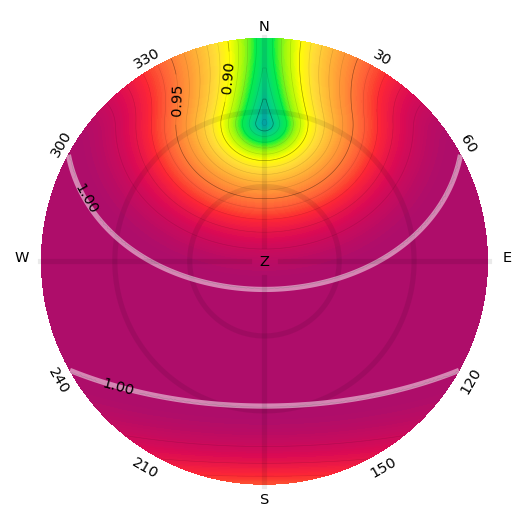

In [41]:
fig, ax = makeFigurePolar()

CS = ax.tricontourf(meshPolar, data_eta_c_max, levels=np.arange(0.8, 1.001, 0.001), **CS1_params)
CS2 = ax.tricontour(meshPolar, data_eta_c_max, levels=CS.levels[::10], **CS2_params)
CS3 = ax.tricontour(meshPolar, data_eta_c_max, levels=CS.levels[::50], **CS3_params)
ax.clabel(CS3, fmt='%0.2f', manual=[
    toPolarX(350*degree, 15*degree),
    toPolarX(330*degree, 15*degree),
    toPolarX(290*degree, 15*degree),
    toPolarX(230*degree, 15*degree)
], **CL_params)

makePolarGrid(ax, elevlab=False, zones=False)
#fig.savefig("eta_c_max.png", dpi=300)

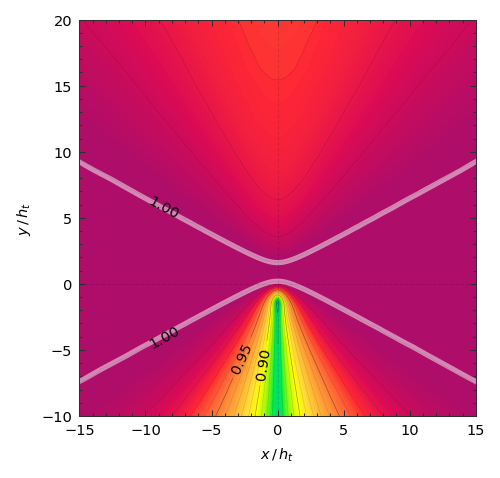

In [42]:
fig, ax = makeFigureHorizontal()

CS = ax.tricontourf(meshHorizontal, data_eta_c_max, levels=np.arange(0.8, 1.001, 0.001), **CS1_params)
CS2 = ax.tricontour(meshHorizontal, data_eta_c_max, levels=CS.levels[::10], **CS2_params)
CS3 = ax.tricontour(meshHorizontal, data_eta_c_max, levels=CS.levels[::50], **CS3_params)
ax.clabel(CS3, fmt='%0.2f', manual=[
    [-8, -5],
    [-8, 7],
    [-4., -5],
    [-1., -6]
], **CL_params)

makeHorizontalGrid(ax)
# fig.savefig("eta_c_max_z.png", dpi=300)

In [43]:
[
    np.min(data_eta_c_max),
    math.cos((90*degree - deltaMax)/2)
]

[0.8379899499559903, 0.8358073613682703]

## Collision safety

In [44]:
# horizontal
def mirrorDensitySigma(r: float)-> float:
#     if r <= r_TN: return 0.
    tz = 1./math.sqrt(1. + r**2)
    eta_c_max = 1.
    return min(sigma_N, tz/eta_c_max)

In [45]:
rs = np.linspace(0.001, 10., 100)
sigmas = [mirrorDensitySigma(r) for r in rs]

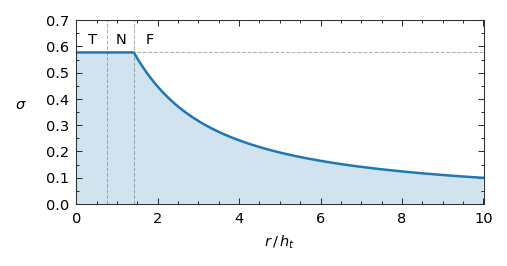

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(3.5, 1.7)
fig.set_dpi(150)

ax.plot(rs, sigmas, linewidth=1.2)
ax.fill_between(rs, sigmas, 0, alpha=0.20)
#ax.fill_between(rTs, sigmaTs, 0, edgecolor='gray', facecolor='none', hatch='///')

ax.set_xlabel(r'$r \, / \, h_t$')
ax.set_xlim(0., 10.001)
ax.xaxis.set_major_locator(mtick.MultipleLocator(2))
ax.xaxis.set_minor_locator(mtick.MultipleLocator(0.5))

ax.set_ylabel(r'$\sigma$', rotation=0, labelpad=12)
ax.set_ylim(0., 0.7)
ax.yaxis.set_major_locator(mtick.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.05))

ax.tick_params(which='both', direction='in', top=True, right=True, width=0.5, color=colorAxes)
ax.tick_params(which='major', length=3)
ax.tick_params(which='minor', length=1.5)

for spine in ax.spines.values():
    spine.set_edgecolor(colorAxes)
    spine.set_linewidth(0.5)
            
ax.text(0.4, 0.61, "T", ha='center')  
ax.text(1.1, 0.61, "N", ha='center')  
ax.text(1.8, 0.61, "F", ha='center')  

for v in [r_TN, r_NF]:
    ax.axvline(x=v, c=colorGrid, ls='--', lw=0.5, zorder=-1)
for v in [sigma_N]:
    ax.axhline(y=v, c=colorGrid, ls='--', lw=0.5, zorder=-1)

plt.tight_layout(rect=[-0.02, -0.05, 0.95, 1])

# fig.savefig("sigma.pdf", dpi=300)

## Tower infrastructure

In [47]:
1/math.sin(4.65e-3)**2

46248.454504852314

In [48]:
def funcPsi(alpha):
    return alpha + math.sin(2*alpha)/2

In [49]:
funcPsi(alpha_TN)/funcPsi(90*degree)

0.8959119613381722

## Shadowing losses

## Visibility factor

In [50]:
data_eta_v_av = [eta_v_av(t, sigma_CB(t)) for t in tqdm_notebook(data_pV)]

  0%|          | 0/32400 [00:00<?, ?it/s]

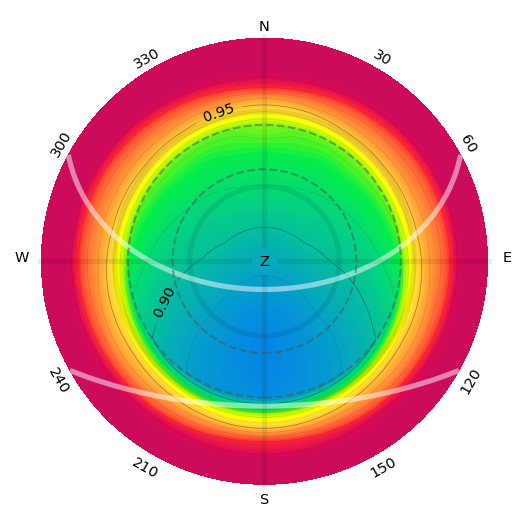

In [51]:
fig, ax = makeFigurePolar()

CS = ax.tricontourf(meshPolar, data_eta_v_av, levels=np.arange(0.8, 1.01, 0.001), **CS1_params,
                    norm=matplotlib.colors.Normalize(0.87, 1))
CS2 = ax.tricontour(meshPolar, data_eta_v_av, levels=CS.levels[::10], **CS2_params)
CS3 = ax.tricontour(meshPolar, data_eta_v_av, levels=CS.levels[::50], **CS3_params)
ax.clabel(CS3, fmt='%0.2f', manual=[
    [-0.2, 0.65],
    [-0.4, -0.2]
], **CL_params)

makePolarGrid(ax, elevlab=not True)
# fig.savefig("eta_v_av.png", dpi=300)

In [52]:
data_eta_v_av_1 = [eta_v_av(t, 1.) for t in data_pV]

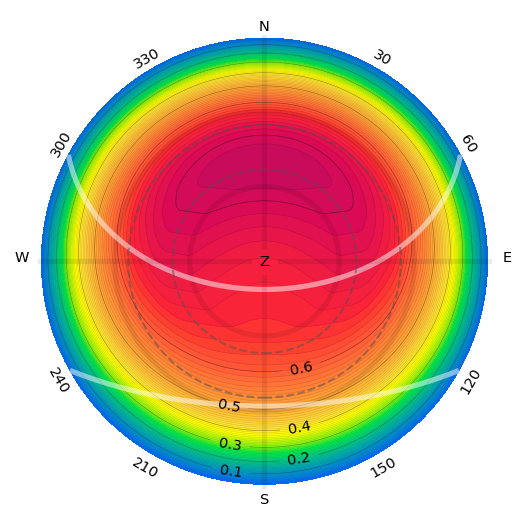

In [53]:
fig, ax = makeFigurePolar()

CS = ax.tricontourf(meshPolar, data_eta_v_av_1, levels=np.arange(0., 1.01, 0.01), **CS1_params,
                    norm=matplotlib.colors.Normalize(0., 0.75))
CS2 = ax.tricontour(meshPolar, data_eta_v_av_1, levels=CS.levels[::1], **CS2_params)
CS3 = ax.tricontour(meshPolar, data_eta_v_av_1, levels=CS.levels[::10], **CS3_params)
ax.clabel(CS3, fmt='%0.1f', manual=[
    [0.15, -0.4],
    [-0.15, -0.6],
    [0.15, -0.7],
    [-0.15, -0.8],
    [0.15, -0.85], 
    [-0.15, -0.95]
], **CL_params)

makePolarGrid(ax, elevlab=not True)
# fig.savefig("eta_v_av_1.png", dpi=300)

# Design of heliostat fields

## Balanced mirror density

0.4


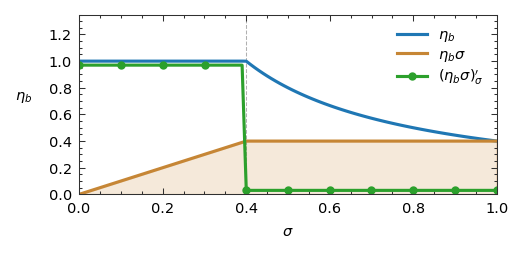

In [54]:
fig = plotBalancing(0, 0, 0.5, 0, etaText=r'\eta_b')
# fig.savefig("eta_sigma_b.pdf", dpi=300)

0.34387049939953584


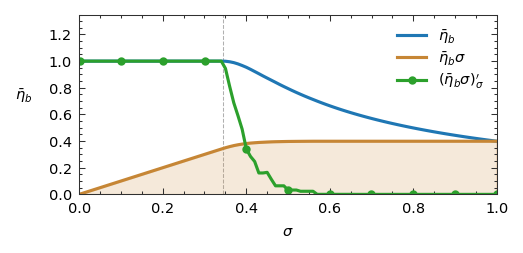

In [55]:
fig = plotBalancing(180, 20, 0.5, 0e-5, etaText=r'\bar{\eta}_b')
# fig.savefig("eta_sigma_b_av.pdf", dpi=300)

0.34387049939953584


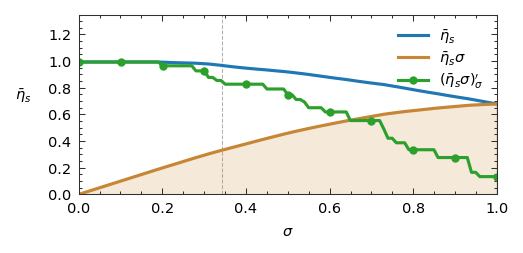

In [56]:
fig = plotBalancing(180, 20, 0.5, 0e-5, etaText=r'\bar{\eta}_s')
# fig.savefig("eta_sigma_s_av.pdf", dpi=300)

0.34387049939953584


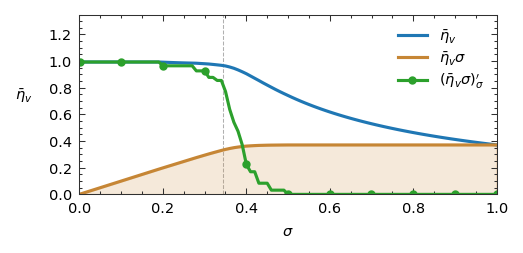

In [57]:
fig = plotBalancing(180, 20, 0.5, 0e-5, etaText=r'\bar{\eta}_v')
# fig.savefig("eta_sigma_v_av.pdf", dpi=300)

0.3645959706020491


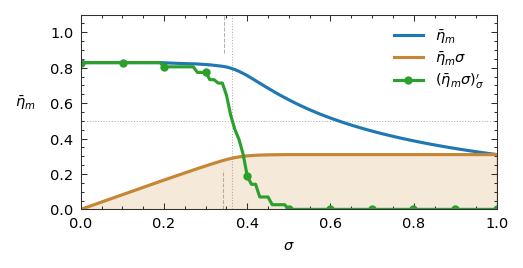

In [58]:
fig = plotBalancing(180, 20, 0.5, 0e-5)
# fig.savefig("eta_sigma_180_20.pdf", dpi=300)

0.4298856495336864


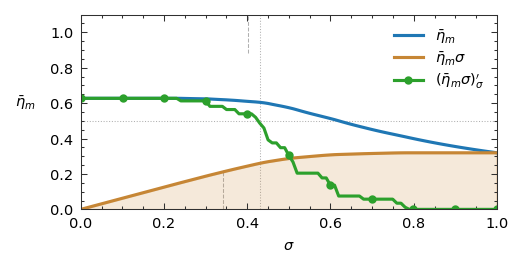

In [59]:
fig = plotBalancing(0, 20, 0.5, 0e-5)
# fig.savefig("eta_sigma_0_20.pdf", dpi=300)

In [60]:
eta_B = 0.5
sigmas_B = [sigma_Balanced(t, eta_B) for t in tqdm_notebook(data_pV)]

  0%|          | 0/32400 [00:00<?, ?it/s]

In [61]:
data_sigma_impr = [sigma/sigma_CB(t) for t, sigma in zip(data_pV, sigmas_B)]

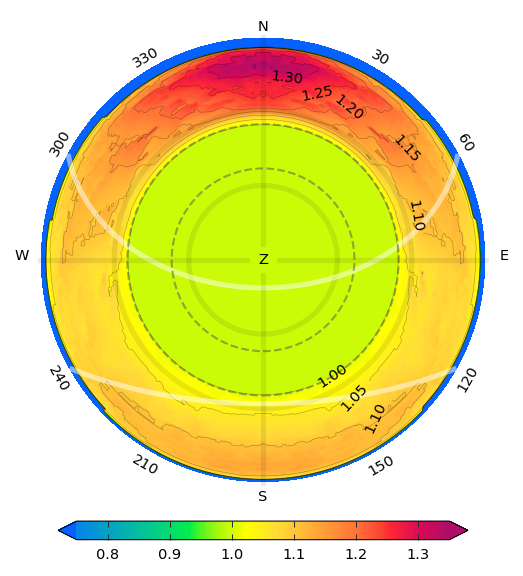

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(3.5, 3.9)
fig.set_dpi(150)
ax.set_aspect('equal')  

CS = ax.tricontourf(meshPolar, data_sigma_impr, levels=np.arange(0.75, 1.35, 0.005), **CS1_params,
                    norm=matplotlib.colors.Normalize(0.7, 1.35))
CS3 = ax.tricontour(meshPolar, data_sigma_impr, levels=CS.levels[::10], **CS3_params)

ax.clabel(CS3, fmt='%0.2f', manual=[
    [0.1, 0.8],
    [0.25, 0.75],
    [0.4, 0.7],
    [0.65, 0.5],
    [0.7, 0.2],
    [0.3, -0.5],
    [0.4, -0.6],
    [0.5, -0.7]
   #, [0.7, 0.3]
   # ,[0.5, 0.7]
], **CL_params)

makePolarGrid(ax, elevlab=not True)

cbar = fig.colorbar(CS, aspect=20, fraction=0.035, pad=0.03, orientation="horizontal")
cbar.ax.tick_params(which='both', direction='in', bottom=True, top=True, width=0.5, color=colorAxes)
cbar.ax.tick_params(which='major', length=3)
cbar.ax.tick_params(which='minor', length=1.5)
cbar.outline.set_linewidth(0.5)
cbar.set_ticks(np.arange(0.7, 1.4, 0.1))
plt.tight_layout(rect=[0.0, 0.0, 1, 1]) # left, bottom, width, height
# fig.savefig("sigma_50.png", dpi=300)

In [63]:
def eta_OmegaCB(t):
    s = sigma_CB(t)
    ds = 0.01*s
    sA = s - ds/2
    sB = s + ds/2
    ans = (eta_cvt_av(t, sB)*sB - eta_cvt_av(t, sA)*sA)/ds 
    return ans

In [64]:
data_eta_OmegaCB = [eta_OmegaCB(t) for t in tqdm_notebook(data_pV)]

  0%|          | 0/32400 [00:00<?, ?it/s]

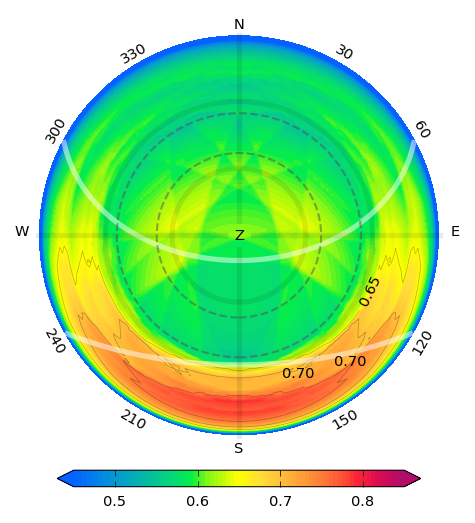

In [65]:
fig, ax = makeFigurePolar()

CS = ax.tricontourf(meshPolar, data_eta_OmegaCB, levels=np.arange(0.45, 0.85001, 0.005), **CS1_params, 
                    norm=matplotlib.colors.Normalize(0.45, 0.85))
# CS2 = ax.tricontour(meshPolar, data_eta_OmegaCB, levels=CS.levels[::1], **CS2_params)
CS3 = ax.tricontour(meshPolar, data_eta_OmegaCB, levels=CS.levels[40::10], **CS3_params)
# plt.text(0, -0.85, "0.8", ha='center', va='center')
ax.clabel(CS3, fmt='%0.2f', manual=[
    [0.3, -0.7],
    [0.5, -0.6],
    [0.7, -0.3]
   #, [0.7, 0.3]
   # ,[0.5, 0.7]
], **CL_params)

makePolarGrid(ax, elevlab=not True)

cbar = fig.colorbar(CS, aspect=20, fraction=0.035, pad=0.03, orientation="horizontal")
cbar.ax.tick_params(which='both', direction='in', bottom=True, top=True, width=0.5, color=colorAxes)
cbar.ax.tick_params(which='major', length=3)
cbar.ax.tick_params(which='minor', length=1.5)
cbar.outline.set_linewidth(0.5)
cbar.set_ticks(np.arange(0., 1., 0.1))
plt.tight_layout(rect=[0.0, 0.0, 1, 1]) # left, bottom, width, height
# fig.savefig("eta_OmegaCB.png", dpi=300)

## Annual efficiency maps

### Main

In [66]:
data_eta_c_av = [eta_c_av(t) for t in tqdm_notebook(data_pV)]

  0%|          | 0/32400 [00:00<?, ?it/s]

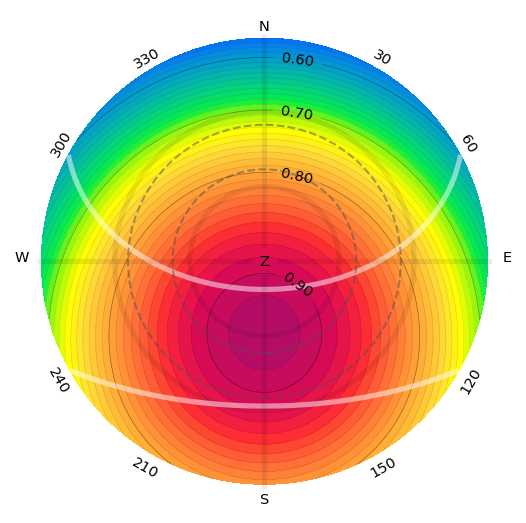

In [67]:
fig, ax = makeFigurePolar()

CS = ax.tricontourf(meshPolar, data_eta_c_av, levels=np.arange(0.5, 1, 0.01), **CS1_params, 
                    norm=matplotlib.colors.Normalize(0.55, 0.92))
CS2 = ax.tricontour(meshPolar, data_eta_c_av, levels=CS.levels[::1], **CS2_params)
CS3 = ax.tricontour(meshPolar, data_eta_c_av, levels=CS.levels[::10], **CS3_params)
ax.clabel(CS3, fmt='%0.2f', manual=[
    [0.15, -0.1],
    [0.15, 0.4],
    [0.15, 0.7],
    [0.15, 0.9]
], **CL_params)

makePolarGrid(ax, elevlab=not True)
# fig.savefig("eta_c_av.png", dpi=300)

In [68]:
data_eta_t = [eta_t(t) for t in data_pV]
data_eta_ct_av = np.array(data_eta_c_av)*np.array(data_eta_t)

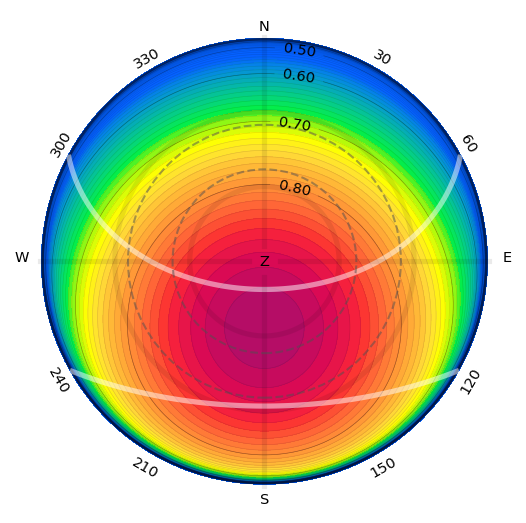

In [69]:
fig, ax = makeFigurePolar()

CS = ax.tricontourf(meshPolar, data_eta_ct_av, levels=np.arange(0., 1, 0.01), **CS1_params, 
                    norm=matplotlib.colors.Normalize(0.55, 0.9))
CS2 = ax.tricontour(meshPolar, data_eta_ct_av, levels=CS.levels[::1], **CS2_params)
CS3 = ax.tricontour(meshPolar, data_eta_ct_av, levels=CS.levels[::10], **CS3_params)
ax.clabel(CS3, fmt='%0.2f', manual=[
    [0.15, 0.4],
    [0.15, 0.7],
    [0.15, 0.8],
    [0.15, 0.9]
], **CL_params)

makePolarGrid(ax, elevlab=not True)
# fig.savefig("eta_ct_av.png", dpi=300)

In [70]:
data_eta_cvt_avCB = [eta_cvt_av(t, sigma_CB(t)) for t in tqdm_notebook(data_pV)]

  0%|          | 0/32400 [00:00<?, ?it/s]

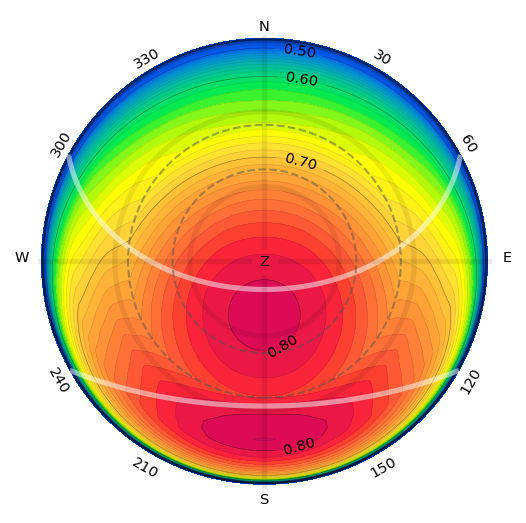

In [71]:
fig, ax = makeFigurePolar()

CS = ax.tricontourf(meshPolar, data_eta_cvt_avCB, levels=np.arange(0., 1, 0.01), **CS1_params, 
                    norm=matplotlib.colors.Normalize(0.5, 0.83))
CS2 = ax.tricontour(meshPolar, data_eta_cvt_avCB, levels=CS.levels[::1], **CS2_params)
CS3 = ax.tricontour(meshPolar, data_eta_cvt_avCB, levels=CS.levels[::10], **CS3_params)
ax.clabel(CS3, fmt='%0.2f', manual=[
    [0.15, 0.4],
    [0.15, 0.7],
    [0.15, 0.9],
    [0.15, -0.5],
    [0.15, -0.8]
], **CL_params)

makePolarGrid(ax, elevlab=not True)
# fig.savefig("eta_cvt_av.png", dpi=300)

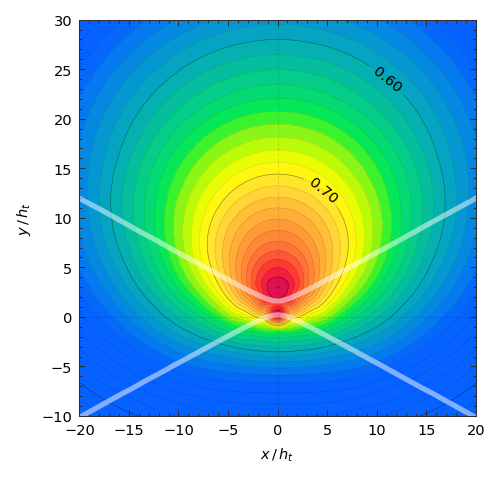

In [72]:
fig, ax = makeFigureHorizontal()
ax.set_xlim(-20, 20)
ax.set_ylim(-10, 30)

CS = ax.tricontourf(meshHorizontal, data_eta_cvt_avCB, levels=np.arange(0.2, 1., 0.01), **CS1_params, 
                    norm=matplotlib.colors.Normalize(0.55, 0.83))
CS2 = ax.tricontour(meshHorizontal, data_eta_cvt_avCB, levels=CS.levels[::1], **CS2_params)
CS3 = ax.tricontour(meshHorizontal, data_eta_cvt_avCB, levels=CS.levels[::10], **CS3_params)
ax.clabel(CS3, fmt='%0.2f', manual=[
    [4., 12],
    [12., 25]
], **CL_params)

makeHorizontalGrid(ax)
# fig.savefig("eta_cvt_av_z.png", dpi=300)

### Filled

In [73]:
gs = sampleInterval(0*degree, 360*degree, 2*degree, True) # gammas for integration
tzis = sampleInterval(1., 200., 1., True) # inverse tzs, 1 is under tower, max mirror area 200*6
gStep = gs[1] - gs[0]
tziStep = tzis[1] - tzis[0]
dAm1 = gStep*tziStep
tzMax = math.sin(alpha_TN)

data_gt_2D = [[
    sp.PointHorizontal(gamma, math.asin(1./tzi))
for tzi in tzis]
for gamma in gs]
data_gt = np.array(data_gt_2D).flatten()
data_pvs = [sunCalculator.findVectorFromHorizontal(q) for q in data_gt]

In [74]:
tzs = [t.z for t in data_pvs] # tzs
sCBs = [sigma_CB(t) for t in data_pvs] # sigmas
etams = [eta_cvt_av(t, sigma_CB(t)) for t in tqdm_notebook(data_pvs)] # efficiency

  0%|          | 0/35820 [00:00<?, ?it/s]

In [75]:
def fillMirrors():
    global func_Af_Am
    global func_etam_Am
    global func_etaf_Am

    list_ase = list(zip(tzs, sCBs, etams))
    list_ase.sort(key=lambda x: x[2], reverse=True) # sort by decreasing mirror efficiency
    
    list_ae = []
    Am = 0.
    Af = 0.
    etaIntegral = 0.
    for tz, sigma, eta_m in list_ase:
        if tz >= tzMax or sigma == 0.: continue
        dAf = dAm1/tz
        Am += sigma*dAf
        Af += dAf
        etaIntegral += eta_m*sigma*dAf
        list_ae.append([Am, Af, eta_m, etaIntegral/Am])
    list_ae = np.array(list_ae)
      
    func_Af_Am = PchipInterpolator(list_ae[:, 0], list_ae[:, 1])
    func_etam_Am = PchipInterpolator(list_ae[:, 0], list_ae[:, 2])
    func_etaf_Am = PchipInterpolator(list_ae[:, 0], list_ae[:, 3])

    Ams = np.linspace(0.1, 200, 100)
    Afs = [float(func_Af_Am(a)) for a in Ams]
    eta_ms = [float(func_etam_Am(a)) for a in Ams]
    eta_fs = [float(func_etaf_Am(a)) for a in Ams]
    return Ams, Afs, eta_ms, eta_fs

In [76]:
Ams, Afs, eta_ms, eta_fs = fillMirrors()

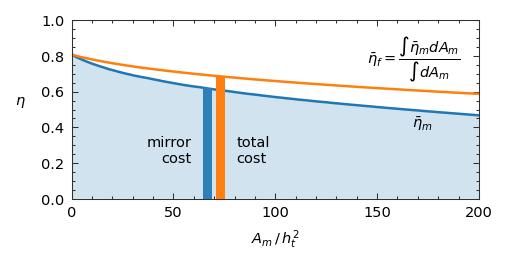

In [77]:
fig, ax = plt.subplots()

fig.set_size_inches(3.5, 1.7)
fig.set_dpi(150)
ax.plot(Ams, eta_ms, linewidth=1.2)
ax.fill_between(Ams, eta_ms, 0, alpha=0.20)
ax.plot(Ams, eta_fs, linewidth=1.2)

ax.set_xlabel(r'$A_m \, / \, h_t^2$')
ax.set_xlim(0, 200)
ax.xaxis.set_major_locator(mtick.MultipleLocator(50))
ax.xaxis.set_minor_locator(mtick.MultipleLocator(10))

ax.set_ylabel(r'$\eta$', rotation=0, labelpad=10)
ax.set_ylim(0., 1)
ax.yaxis.set_major_locator(mtick.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.05))

ax.tick_params(which='both', direction='in', top=True, right=True, width=0.5, color=colorAxes)
ax.tick_params(which='major', length=3)
ax.tick_params(which='minor', length=1.5)

for spine in ax.spines.values():
    spine.set_edgecolor(colorAxes)
    spine.set_linewidth(0.5)
            
ax.text(145, 0.76, r"$\bar{\eta}_f = \dfrac{\int{\bar{\eta}_m d A_m}}{\int{d A_m}}$")  
# ax.text(116, 0.395, r"$\eta_m = \eta_f + A_m\dfrac{d\eta_f}{dA_m}$")  
ax.text(167, 0.4, r"$\bar{\eta}_m$")  

ax.text(59, 0.2, "mirror\ncost", ha='right')  
ax.text(81, 0.2, "total\ncost", ha='left')  

ax.add_patch(
    patches.Rectangle(
        xy=(64.5, 0.001), width=4.5, height=0.62, linewidth=0,
        color='#2D80B9', zorder=3)
)
ax.add_patch(
    patches.Rectangle(
        xy=(71, 0.001), width=4.5, height=0.68, linewidth=0,
        color='#FF8011', zorder=3)
)
# for v in [100]:
#     ax.axvline(x=v, c=colorGrid, ls='--', lw=0.5, zorder=-1)
# for v in [0.5]:
#     ax.axhline(y=v, c=colorGrid, ls='--', lw=0.5, zorder=-1)

plt.tight_layout(rect=[-0.02, -0.05, 0.95, 1])
plt.show()
# fig.savefig("eta_f_av.png", dpi=300)

### Balanced

In [78]:
def findBalancedField(eta_B: float):
    Am = 0.
    Af = 0.
    etaIntegral = 0.
    for t in tqdm_notebook(data_pvs):
        if t.z >= tzMax: continue # exclude tower
        sigma = sigma_Balanced(t, eta_B)
        if sigma == 0.: continue # exclude boundary
        dAf = dAm1/t.z
        Am += sigma*dAf
        Af += dAf
        etaIntegral += eta_cvt_av(t, sigma)*sigma*dAf
    return Am, Af, eta_B, etaIntegral/Am

In [79]:
AmB, AfB, eta_B, eta_fB = findBalancedField(0.6)

  0%|          | 0/35820 [00:00<?, ?it/s]

In [80]:
[AmB, AfB, eta_fB, func_etam_Am(AmB), func_etaf_Am(AmB), func_Af_Am(AmB)]

[80.15208955056181,
 818.4721465534521,
 0.6802086335943863,
 array(0.59758218),
 array(0.67839918),
 array(857.83238137)]